# Combatting overfitting through data augmentation and dropout regularisation

Import dependencies from prev steps

In [23]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
from matplotlib import pyplot as plt

Import and initialise our unaugmented data first

In [12]:
# setup general info on batch sizes and img sizes
batch_size = 32
img_height = 256
img_width = 256

In [13]:
# generate training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    "Cars",
    validation_split= 0.2, # let the program know what the validation split will be in order to choose the correct size of this training set as well
    subset="training", # here we denote that this set will be the *training* set.
    seed=123,
    image_size = (img_height, img_width), # rescale images automatically
    batch_size= batch_size
) 

Found 3697 files belonging to 5 classes.
Using 2958 files for training.


In [14]:
# generate validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    "Cars",
    validation_split= 0.2,
    subset="validation", # here we denote that this set will be the *validation* set.
    seed=123, 
    image_size = (img_height, img_width),
    batch_size= batch_size
)

Found 3697 files belonging to 5 classes.
Using 739 files for validation.


In [15]:
# automatic labelling with this object, based on dict names.
class_names = train_ds.class_names

In [26]:
# taken from tf tutorial, unknown what this does so far
AUTOTUNE = tf.data.AUTOTUNE

# randomly shuffle your data.
train_ds_pref = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# function of this line is currently unknown.
val_ds_pref = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data augmentation

Now that we've imported the initial data, we can perform the actual data augmentation.

In [16]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Let's visualise an example:

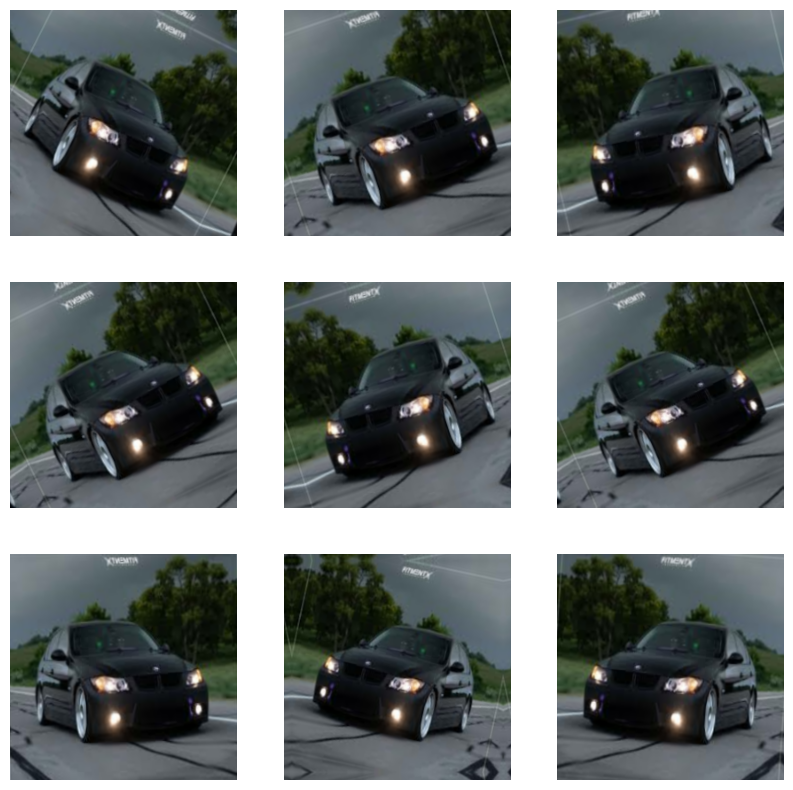

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

With this function in place, we can generate a much larger dataset for our network to train on. Since larger $N_{data}$ is always better, this will of course improve performance.

## Dropout regularisation

However, generally, overfitting is tackled using also [*regularisation*](https://www.youtube.com/watch?v=NhZVe50QwPM). For this, TF recommends *dropout*, a rather new regularisation technique in which for each training sample, a number of activations are (at random) turned off completely. This forces the network to never be able to rely on one single activation, as it may be turned off at any point, and thus it must make a number of 'redundant' ways of classifying images. While this at first seems highly inefficient, it forces the network to get anwsers based on the 'consensus' of multiple activations, making the network generally more robust and much less prone to overfit.

In [21]:
from tensorflow.keras.layers import Dropout

With all this included, our new model looks like this:

In [25]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation, # data augmentation as a very first step
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # here we perform the dropout.
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [27]:
# compile the model
model.compile(optimizer='adam', # choose the optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # loss function is same as error function
              metrics=['accuracy']) # choose which metrics to keep track of during optimization

In [28]:
# provide overview of the model dataflow
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                 

In [29]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


KeyboardInterrupt: 